In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import pandas_datareader.data as web

def get_factors(factors='CAPM',freq='daily'):   
    
    if freq=='monthly':
        freq_label=''
    else:
        freq_label='_'+freq


    if factors=='CAPM':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
    
     
        df_factor = daily_data[['RF','Mkt-RF']] 
    elif factors=='FF3':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
    elif factors=='FF5':

        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')    
        
    else:
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')   
        fama_french = web.DataReader("F-F_Momentum_Factor"+freq_label, "famafrench",start="1921-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')
        df_factor.columns=['RF','Mkt-RF','SMB','HML','RMW','CMA','MOM']    
    if freq=='monthly':
        df_factor.index = pd.to_datetime(df_factor.index.to_timestamp()+ pd.offsets.MonthEnd(0))
    else:
        df_factor.index = pd.to_datetime(df_factor.index)
        


    return df_factor/100



# Expected Return Timing 

The most classic timing strategies are motivated by the fact that high dividend yield periods seems to be followed by above average returns

The plot shows the dividend-yield of the stock market overlayed with the future 7 year returns 
![MVfrontier](../../assets/plots/Timing1.jpg)

It tell us that in this sample, periods when the dividend yield was high were periods where the returns were really high going forward.

This might be intuitive to you, but it is really a fact that puzzled lots of people and earned Robert Shiller a nobel prize

<img src="https://som.yale.edu/sites/default/files/styles/square_1280/public/profile_pictures/shiller-bob.jpg.webp?itok=TgThr2LT" alt="Rober shiller" style="width: 50%;">


It tells us that when the price (per dividend) is low what actually happens is NOT that the dividends go down going forward which would be intuitive--if the price is low is probably because payouts will be low-- but instead prices go up--meaning expected returns were high!

So this suggests EXPECTED returns to invest in the market change a lot overtime.

A trading strategy that exploits this would have weights that depend on the dividend yield signal.






In [35]:
#!pip install wrds 
# import wrds
db = wrds.Connection()
crsp_sql = f"""
    SELECT date, vwretd, vwretx
    FROM crsp.msi
    ORDER BY date;
"""
crsp = db.raw_sql(crsp_sql, date_cols=['date'])
crsp['dp'] = (1.0 + crsp['vwretd']) / (1.0 + crsp['vwretx']) - 1.0
crsp = crsp.set_index('date')
crsp

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,vwretd,vwretx,dp
date,,,
1925-12-31,NaN,NaN,NaN
1926-01-30,0.000561,-0.001395,0.001959
1926-02-27,-0.033046,-0.036587,0.003675
1926-03-31,-0.064002,-0.070021,0.006472
1926-04-30,0.037029,0.034043,0.002888
...,...,...,...
2024-08-30,0.021572,0.020203,0.001342
2024-09-30,0.020969,0.019485,0.001456
2024-10-31,-0.008298,-0.009139,0.000849


<Axes: xlabel='date'>

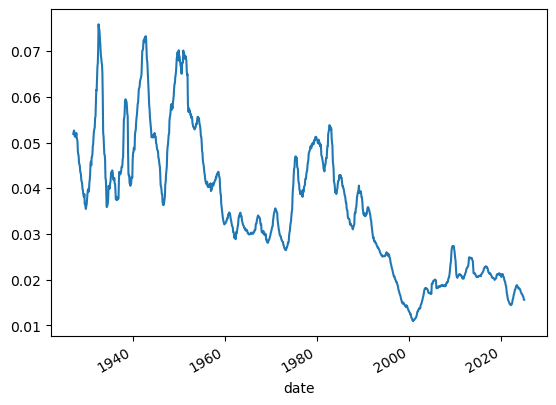

In [38]:
# we will average over 1 year to get rid of seasonality and noise in general
# we will also multiply by 12 to get the annualized dividend yield
(crsp.dp.rolling(window=12).mean()*12).plot()

- dividend yields went from 4%-7% in the start of the sample (1930's) to around 2% now

- We will now look at the relationship between dividend yields and  5-year ahead returns
- That is, I will ask the regression to tell me: if I see a high dividend-yield what does typically happen with the returns of my investment in the market if I buy it and hold it for 5 years
- Because this story is mostly about risk-premia we will take out the risk-free rate

c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)
c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)


<Axes: >

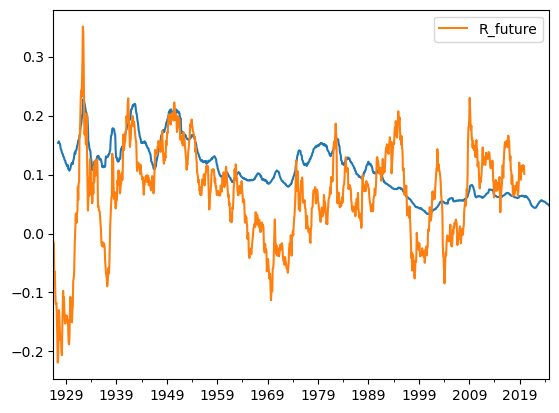

In [96]:
df = get_factors('CAPM', freq='monthly').dropna()

# We align the indices of the CRSP data and the Fama-French data 
# they are both monthly data but wrds has the actual last trading date of the month while 
# the Fama-French data has the last calendar day of the month

crsp.index = crsp.index+pd.offsets.MonthEnd(0)
years=5
merged_data = crsp.merge(df[['RF']], left_index=True, right_index=True)
# here we cumulate the excess returns over the next 5 years
# we do that by first taking a rolling product of gross returns--the windown is backwards looking
# then we shift the result by 5 years to get the future returns
merged_data['R_future']= (1+merged_data['vwretd']-merged_data['RF']).rolling(window=years*12).apply(np.prod).shift(-years*12)**(1/years)-1
# I averaging the dividend yield to get rid of seasonality and noise
# a simiar possibility would be to add the dividends for the last 12 months and divide by the price at the end of the period
# I am multiplying by 12 to get the annualized dividend yield
merged_data['dp_avg'] = merged_data.dp.rolling(window=12).mean()*12
#finally I multiply the dividend yield by 3 to make it more visible in the plot
ax=(merged_data['dp_avg']*3).plot()
merged_data[['R_future']].plot(ax=ax)

In [97]:
#raw correlation suggests interesting relationship
# this is predictive
(merged_data['dp_avg']).corr(merged_data['R_future'])

0.3670940450303395

How do you see if the signal works?
- You start with some signal that you know in date $t$ 
- Estimate the forecasting regression 

$$ r_{t+1}=a+b *signal_t+u_{t+1}$$

- The difference from factor models is that the relationship is NOT contemporaneous
- The whole point is to use the fact that you know the signal ahead of time
- That is the signal at date $t$ has information about the return in data $t+1$ (or some longer horizon)
- In fact what we will do below is to try to predict the next 5 years


$$ r_{t\rightarrow t+50}=a+b *signal_t+u_{t+1}$$

- We will be looking at the b coefficient, it's standard errors and the r-squared of this regression


- Is the R-squared meaningful ( we will discuss later ) and the b is well estimate and different from zero?
    - If the answer is no: STOP, the signal does not work even in sample!
    - If yes, then you kick the tires more...



In [85]:
# lets run the regression
import statsmodels.api as sm
X = sm.add_constant(merged_data['dp_avg'] )  
model = sm.OLS(merged_data['R_future'], X, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               R_future   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     161.8
Date:                Thu, 14 Aug 2025   Prob (F-statistic):           1.08e-34
Time:                        16:47:16   Log-Likelihood:                 1299.2
No. Observations:                1111   AIC:                            -2594.
Df Residuals:                    1109   BIC:                            -2584.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0297      0.006      4.878      0.0

WOW! Look at this t-stat!

What do you think? Can we really take it to the bank?



The summary is 
- This regression has many issues and academics have spent a lot of time on it
- There is a relationship but it is weak
- You absolutely cannot take it to the bank
- The big issues are:
  - the variable dividend yield is extremely persistent, so we do not have that much variation in it. Just a few data points even in a long sample
  - The return are overlapping, so when we cumulate the returns we are really double counting the number of observations, so the traditional standard errors are totally off
  - Traditional--but not bullet proof is to use an adjusted standard errors like HAC with a window consistent with the rolling window. We  do that below and does make a huge difference
  - The third issue is that there is a bias in the regression because the innovation in the variables are correlated



In [80]:
import statsmodels.api as sm
X = sm.add_constant(merged_data['dp_avg'] )  
model = sm.OLS(merged_data['R_future'], X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': years*12})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               R_future   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     11.89
Date:                Thu, 14 Aug 2025   Prob (F-statistic):           0.000584
Time:                        14:45:06   Log-Likelihood:                 1299.2
No. Observations:                1111   AIC:                            -2594.
Df Residuals:                    1109   BIC:                            -2584.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0297      0.024      1.232      0.2

one thing that people do to evaluate these forecasting regressions is loot at the R-squared out of sample relative to some benchmark $\mu_{t}$. 



$$R^2_{TS}=1-\frac{(r_{t+1}-(a+b *signal_t))^2}{((r_{t+1})-\mu_{t})^2}$$


A less "academicy" way is to simply see how well the trading strategy does out of sample

How would we do that?


for example you would have a weight 

$$x_t=\frac{(a+b\frac{d_t}{p_t})}{\gamma \sigma^2}$$

- where a b are  the regression coefficient
on the market excess return, and $a+b\frac{d_t}{p_t}$ is our premium forecast
- $\gamma$ is the risk-aversion and $\sigma$ is the volatility of the asset. 


So your strategy return is

$$r_{t+1}=(1-x_t)r^f_{t+1}+x_tr_{t+1}^{mkt}$$

Where you would use to control your average exposure to the market.

Or more simply

$$r_{t+1}=r^f_{t+1}+x_t(r_{t+1}^{mkt}-r^f_{t+1})$$


If x<1, invest in the risk-free rate, if x>1, borrow to fund a bigger position in the risky asset

<Axes: >

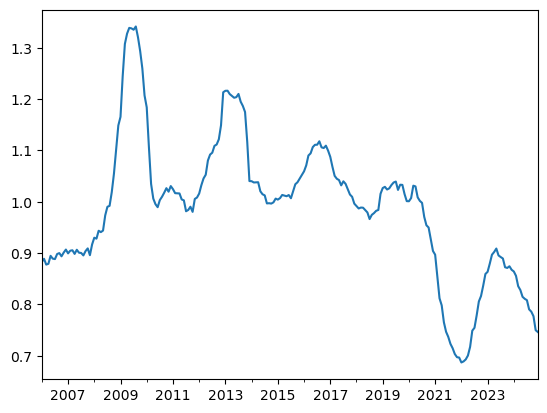

In [106]:
Estimation_sample=merged_data[:'2005'].copy()
Test_sample=merged_data['2006':].copy()
years=5
Estimation_sample['R_future']= (1+Estimation_sample['vwretd']).rolling(window=years*12).apply(np.prod).shift(-years*12)**(1/years)-1

X = sm.add_constant(Estimation_sample['dp_avg'] )  
model = sm.OLS(Estimation_sample['R_future'], X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': years*12})


gamma=2
vol=0.16

Test_sample['premium_forecast']=(model.params['const']+model.params['dp_avg']*Test_sample['dp_avg'])
Test_sample['weight']=Test_sample['premium_forecast']/(gamma*vol**2)

Test_sample['weight'].plot()


- Note that the denominator here $\gamma \sigma^2$ is only impacting your average position in the asset
- An alternative it to pick it so that you have some average desired position in the asset 

We can now directly look at it's performance relative to a buy and hold strategy

<Axes: >

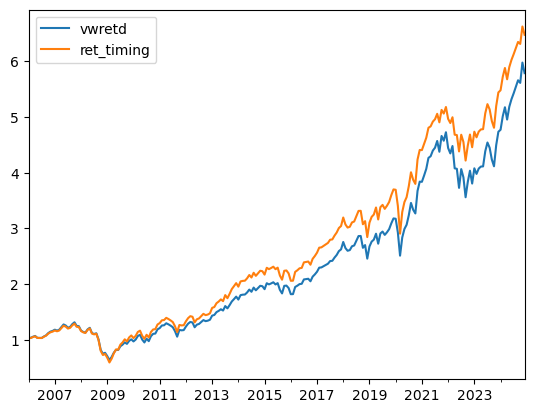

In [107]:

Test_sample['ret_timing']=Test_sample['RF']+Test_sample['weight']*(Test_sample['vwretd']-Test_sample['RF'])

(1+Test_sample[['vwretd','ret_timing']]).cumprod().plot()

But is this the right benchmark for performance?

Here is a different one

Here we use the average return in the estimation sample as our measure of risk-premium

<Axes: >

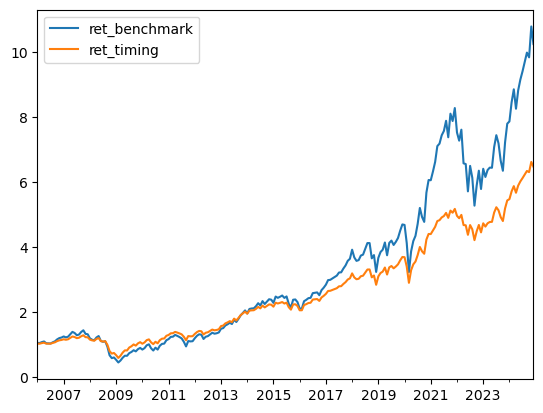

In [108]:
premium_benchmark=(Estimation_sample['vwretd']-Estimation_sample['RF']).mean()*12
Test_sample['weight_benchmark']=premium_benchmark/(gamma*vol**2)
Test_sample['ret_benchmark']=Test_sample['RF']+Test_sample['weight_benchmark']*(Test_sample['vwretd']-Test_sample['RF'])
(1+Test_sample[['ret_benchmark','ret_timing']]).cumprod().plot()

Does it work or not?

How to evaluate?


if you are interested in digging further see

>John Y. Campbell, Samuel B. Thompson, Predicting Excess Stock Returns Out of Sample: Can Anything Beat the Historical Average?, The Review of Financial Studies, Volume 21, Issue 4, July 2008, Pages 1509–1531, https://doi.org/10.1093/rfs/hhm055

- We refer to the dividend-yield as a signal

- There are many other signals that have been show to predict market returns-- in the past

- Harder to know which ones work right now

- Some of the signals are

    - Short interest (The size of short positions relative to the overall market)
      - idea: shorts must know what they are doing and if the short is high things will be bad
    - Variance risk premium (VIX-squared-Realized Variance)
      - If risk-premium in option markets is high, risk premium in equity markets is probably high 
    - Equity issuing activity (fraction of the market being sold)
      - If companies are issuing a lot they must think they are overvalued
    - Aggregate accruals
      - I think the idea here is that accruals capture manipulation so if firms are doing a lot of of it, it might mean that bad news are about to land and returns will be low going forward